# Project CS209: Predict Democratic Elections Through Twitter Data
## Exploratory Data Analysis
### Will Fried, Benjamin Levy, Matthieu Meeus and Dimitris Vamvourellis

This notebook builds further from three distinct prior steps:

**1. Scraping Twitter Data**
A total of approximately 2 million tweets has been collected through the twitter API based on queries associated with the election candiddates considered. In this notebook, the resulting datasets (CSV) are read and combined.

**2. Predicting Sentiment**
On a large tweet dataset with labeled sentiment, an LSTM model has been fit and the resulting weights and model are imported in the beginning of this notebook as sent.predict_sentiment. 

**3. Ground truth Polling Data**
Note that there is no data available of true popularity for the candidates. Therefore, a seperate notebook has attempted to build a cleverly combined model of all polls that have been recorded in the last months. The results are CSV-files used as input to this notebook. 

Now these three steps haven been fulfilled, the data can be explored through visualizations. 

[**Link to download the data**](https://drive.google.com/drive/u/1/folders/1kqZFj4rTtfL4D7No-8u6IZmoz3eySciz)

Note that the Twitter data collected for the purpose of this project has been made publicly available through this link. A dataset that ontains more than 4 million tweets mentioning the five most popular candidates for the 2019 Democratic elections is potentially useful for future projects.

In [1]:
#from twitpol import sentiment as sent
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

In [2]:
# load the data
dataframes = dict()
names = ['Warren', 'Biden', 'Sanders', 'Harris', 'Buttigieg']
for name in names:
    df = pd.read_csv(name + '_sent.csv')
    if name == 'Sanders':
        likes = pd.read_csv('SANDERS_ALL_justlikes.csv')
        df['nlikes'] = likes['nlikes'][:len(df)]
    elif name == 'Harris':
        likes = pd.read_csv('HARRIS_ALL_justlikes.csv')
        df['nlikes'] = likes['nlikes'][:len(df)]
    dataframes[name] = df

In [3]:
dataframes['Harris'].head()

,Unnamed: 0,Unnamed: 0.1,tweet,DateTime,Sentiment,nlikes
0,0,0,trump donated to kamala harris + @SenKamalaHar...,2019-03-01,0.026440,2
1,1,1,He went on the view at the start of woman’s mo...,2019-03-01,0.223448,0
2,2,2,We must be clear that you WILL NOT be that jou...,2019-03-01,0.682366,12
3,3,3,"Kamala ""Blue Lives Matter"" Harris.",2019-03-01,0.709793,1
4,4,4,"Yes, is true. He has what it takes to outmaneu...",2019-03-01,0.670149,1


In [4]:
# collect some tweets with positive and negative sentiment
for name in names:
    print('Sample of {}'.format(name))
    negative = dataframes[name].loc[dataframes[name]['Sentiment'] <= 0.1]
    positive = dataframes[name].loc[dataframes[name]['Sentiment'] >= 0.9]
    neutral = dataframes[name].loc[(dataframes[name]['Sentiment'] <= 0.55)]
    neutral =  neutral.loc[neutral['Sentiment'] >= 0.45]
    for i in range(3,5):
        print('Sentiment of {} for tweet: {}'.format(negative['Sentiment'].iloc[i], negative['tweet'].iloc[i]))
        print('Sentiment of {} for tweet: {}'.format(positive['Sentiment'].iloc[i], positive['tweet'].iloc[i]))
        print('Sentiment of {} for tweet: {}'.format(neutral['Sentiment'].iloc[i], neutral['tweet'].iloc[i]))
    print('------------------------')

Sample of Warren
Sentiment of 0.059682547999999995 for tweet: Fake Indian Elizabeth Warren Gets Heckled For Voting to Support Doctors Killing Babies Who Survive Abortion (VIDEO)  https://www.thegatewaypundit.com/2019/03/fake-indian-elizabeth-warren-gets-heckled-for-voting-to-support-doctors-killing-babies-who-survive-abortion-video/ … via @gatewaypundit
Sentiment of 0.9466593000000001 for tweet: @toddchrisley Hey Todd be in Cherokee Indian are you related to Pocahontas Elizabeth Warren LOL
Sentiment of 0.49685752 for tweet: I thought Doctors took an oath to do all they could to save lives.

BREAKING:
If Cory Booker, Kirsten Gillibrand, Kamala Harris, Amy Klobuchar, Elizabeth Warren, or Bernie Sanders choke on something in public, we are not required to save them!

Be sure to chew your food good!
Sentiment of 0.09245551 for tweet: Fake Indian Elizabeth Warren Gets Heckled For Voting to Support Doctors Killing Babies Who Survive Abortion

 https://www.thegatewaypundit.com/2019/03/fake-in

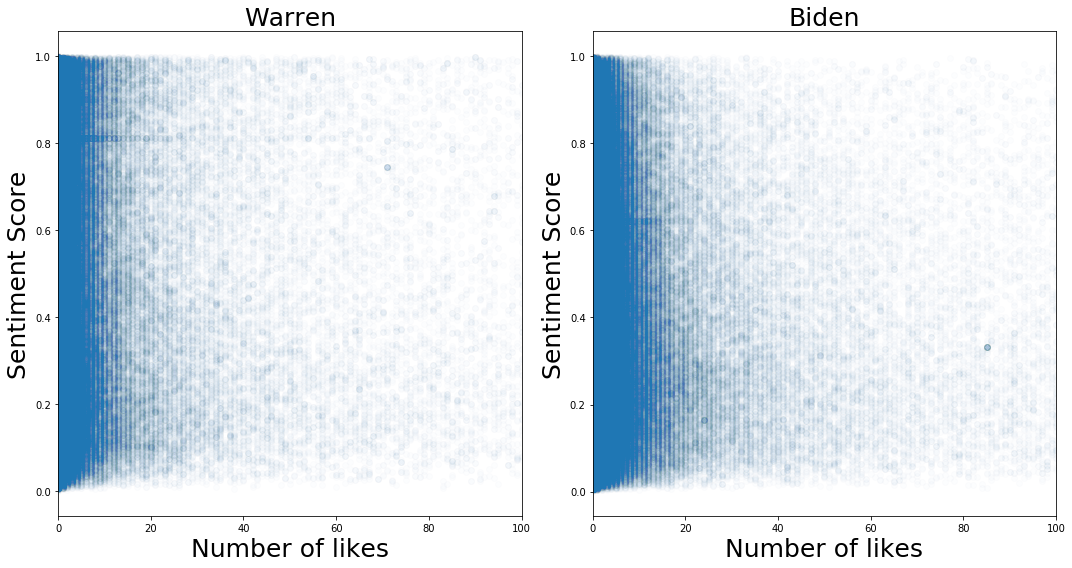

In [5]:
# plot sentiment/likes distribution
fig, axs = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth(15)
df = dataframes['Warren']
axs[0].scatter(df['nlikes'], df['Sentiment'], alpha = 0.01)
axs[0].set_xlabel('Number of likes', fontsize = 25)
axs[0].set_ylabel('Sentiment Score', fontsize = 25)
axs[0].set_title('Warren', fontsize = 25)
df = dataframes['Biden']
axs[1].scatter(df['nlikes'], df['Sentiment'], alpha = 0.01)
axs[1].set_xlabel('Number of likes', fontsize = 25)
axs[1].set_ylabel('Sentiment Score', fontsize = 25)
axs[1].set_title('Biden', fontsize = 25)
axs[0].set_xlim(0,100)
axs[1].set_xlim(0,100)
plt.tight_layout()

In [6]:
# get ground truth
ground_truth_all = pd.read_csv('ground_truth_polling.csv')
ground_truth_all.head()

,Unnamed: 0,Biden,Warren,Sanders,Harris,Buttigieg
0,2019-03-03,33.819893,7.484042,25.342851,9.540914,1.814704
1,2019-03-04,33.819893,7.484042,25.371972,9.533104,1.819717
2,2019-03-05,33.819893,7.484042,25.391386,9.527897,1.823058
3,2019-03-06,33.819893,7.484042,24.945807,9.484149,1.825446
4,2019-03-07,33.819893,7.484042,24.528590,9.441251,1.829362


In [12]:
day_time_truth = ground_truth_all['Unnamed: 0'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))
ground_truth_all['DateTime'] = day_time_truth
days_truth = day_time_truth.apply(lambda x: x.timetuple().tm_yday)
ground_truth_all['Day of the Year'] = days_truth

In [8]:
# find days and likes*sentiment for all df's 
for name in names:
    df = dataframes[name]
    df['DateTime'] = df['DateTime'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))
    days_df = df['DateTime'].apply(lambda x: x.timetuple().tm_yday)
    df['Day of the Year'] = days_df
    # weight sentiment by likes
    df['Sentiment*Likes'] = np.multiply(df['Sentiment'], df['nlikes'])
    dataframes[name] = df

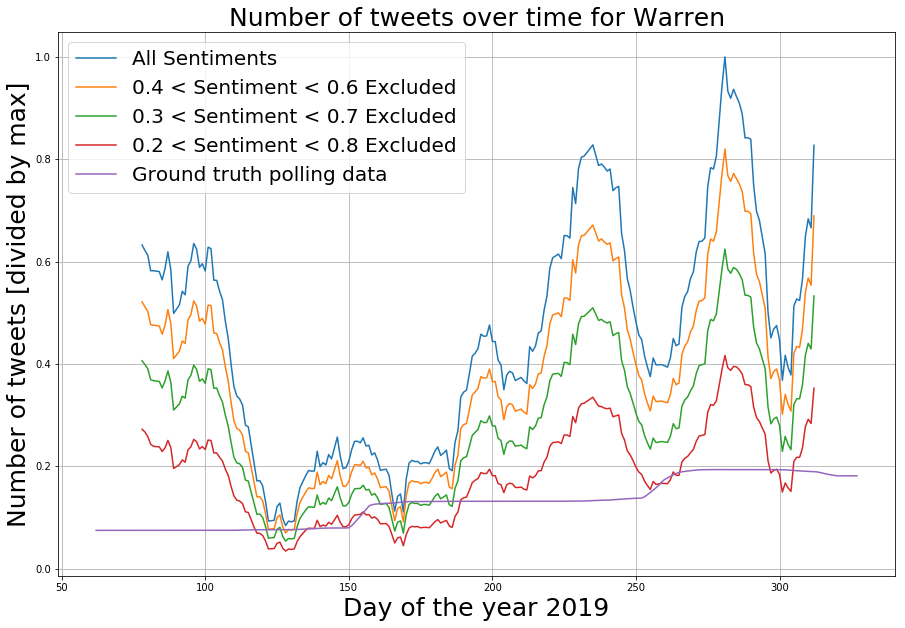

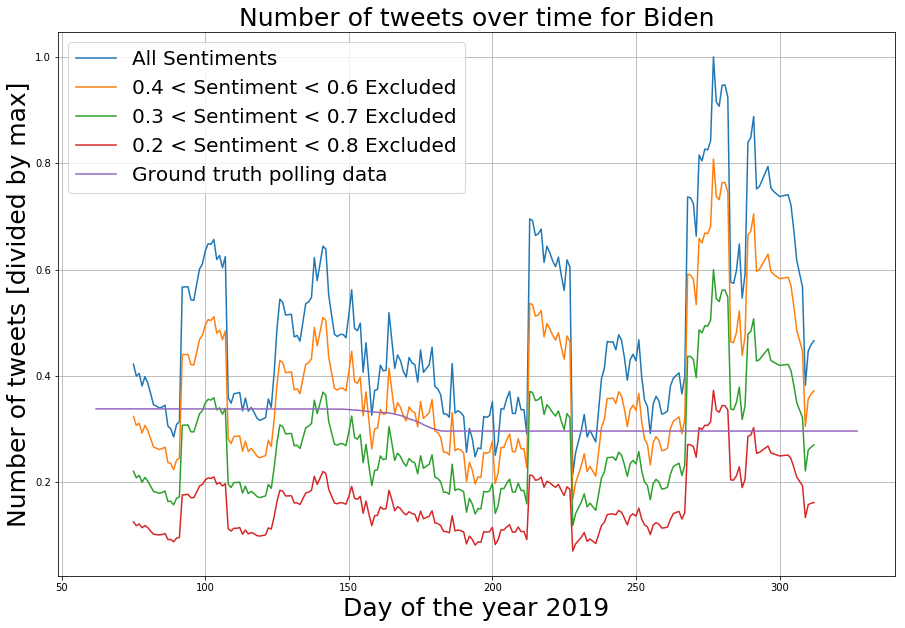

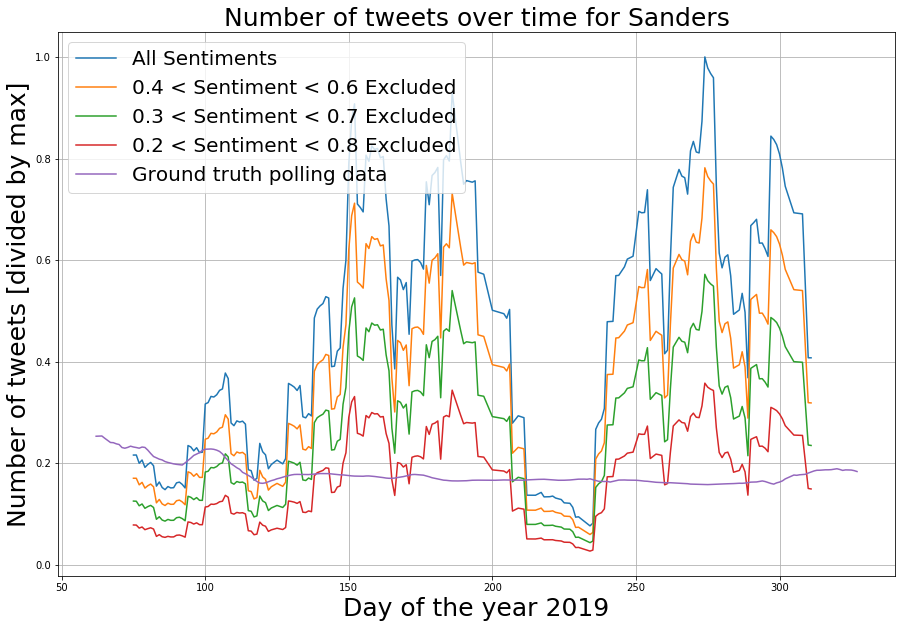

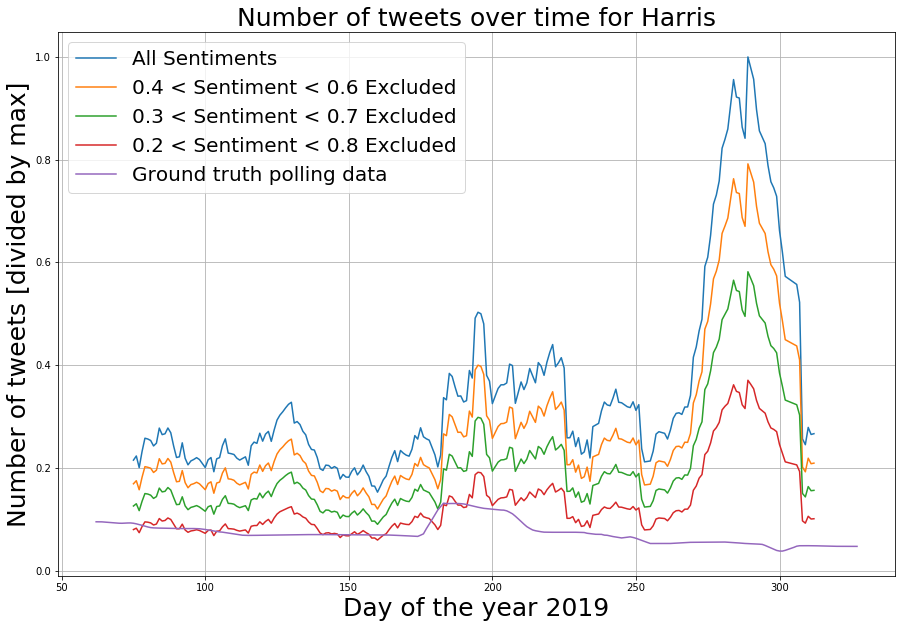

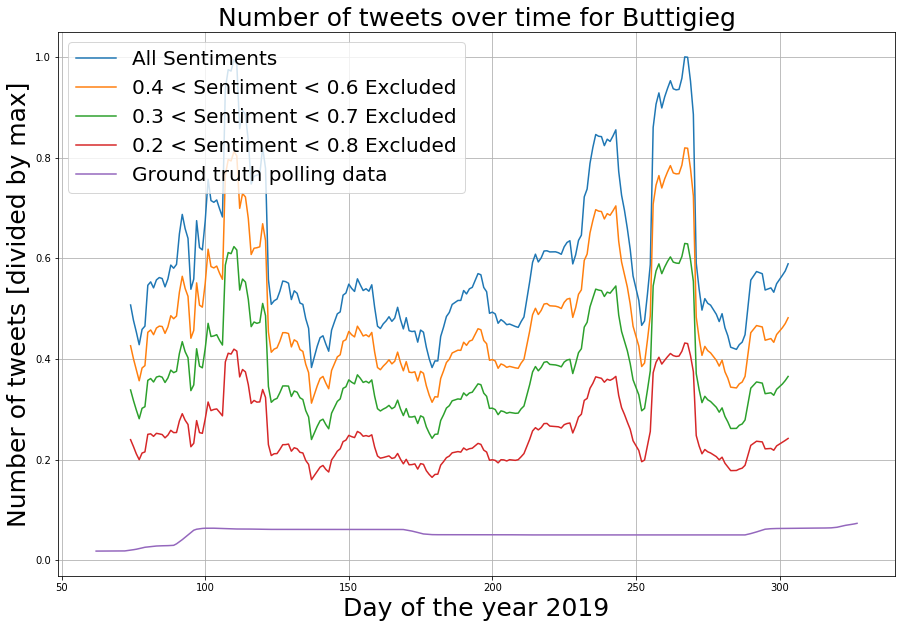

In [9]:
# plot the number of tweets over time for different sentiment cut-offs
for name in names:
    df_large = dataframes[name]
    df_large.sort_values('DateTime', axis=0, ascending=True, inplace=True)
    days_df = df_large.groupby(df_large['Day of the Year']).count().index
    extreme_cutoffs = [0, 0.1, 0.2, 0.3]
    k = 15
    plt.figure(figsize = (15,10))

    for extreme_cutoff in extreme_cutoffs:

        upper_bound = 0.5-extreme_cutoff
        lower_bound = 0.5+extreme_cutoff
        new_df1 = df_large.loc[df_large['Sentiment']>= lower_bound]
        new_df2 = df_large.loc[df_large['Sentiment']<= upper_bound]
        new_df = pd.concat([new_df1, new_df2])
        new_df.sort_values('Day of the Year', axis=0, ascending=True, inplace=True)

        sub_df = new_df.copy()

        # find the count of tweets per day
        nb_tweets_per_day = sub_df.groupby(sub_df['DateTime']).count()['tweet']
        
        # smooth it out
        smoothed_number = pd.Series(nb_tweets_per_day).rolling(k).mean()
        if extreme_cutoff == 0:
            max_nb_smooth = np.max(smoothed_number)
        smoothed_number = smoothed_number/max_nb_smooth
        if extreme_cutoff == 0:
            plt.plot(days_df, smoothed_number, label = 'All Sentiments')
        else:
            plt.plot(days_df, smoothed_number, label = '{} < Sentiment < {} Excluded'.format(upper_bound, lower_bound))

    plt.plot(days_truth, ground_truth_all[name]/100, label = 'Ground truth polling data')
    plt.title('Number of tweets over time for {}'.format(name), fontsize = 25)
    plt.xlabel('Day of the year 2019', fontsize = 25)
    plt.ylabel('Number of tweets [divided by max]', fontsize = 25)
    plt.legend(fontsize = 20)  
    plt.grid()

C:\Users\Matthieu\Pictures\Anaconda3_2\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


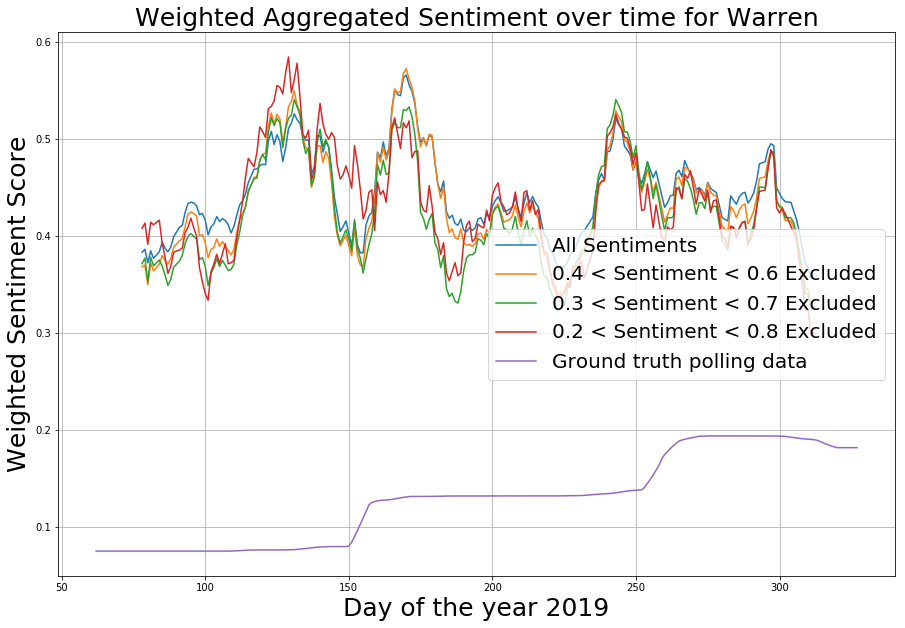

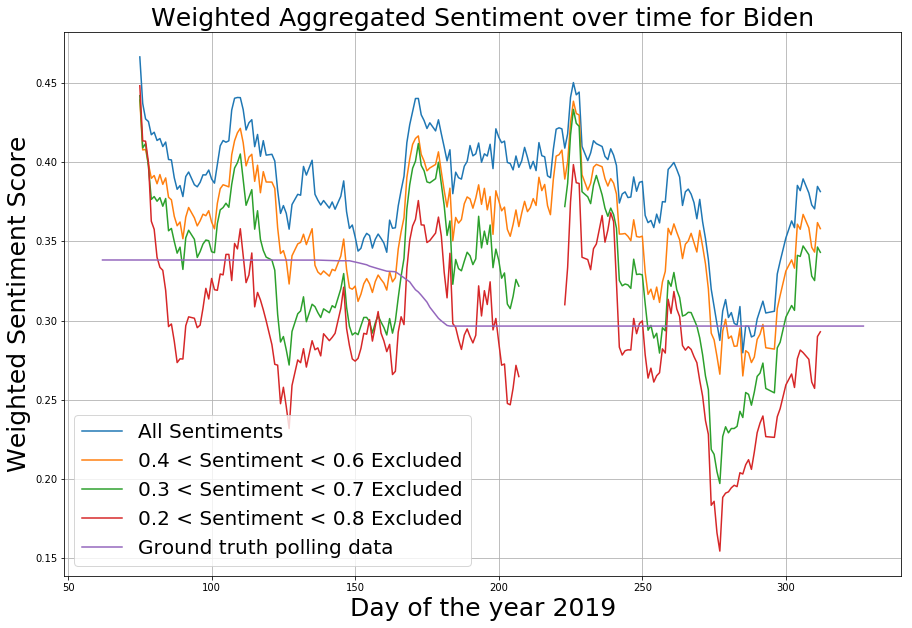

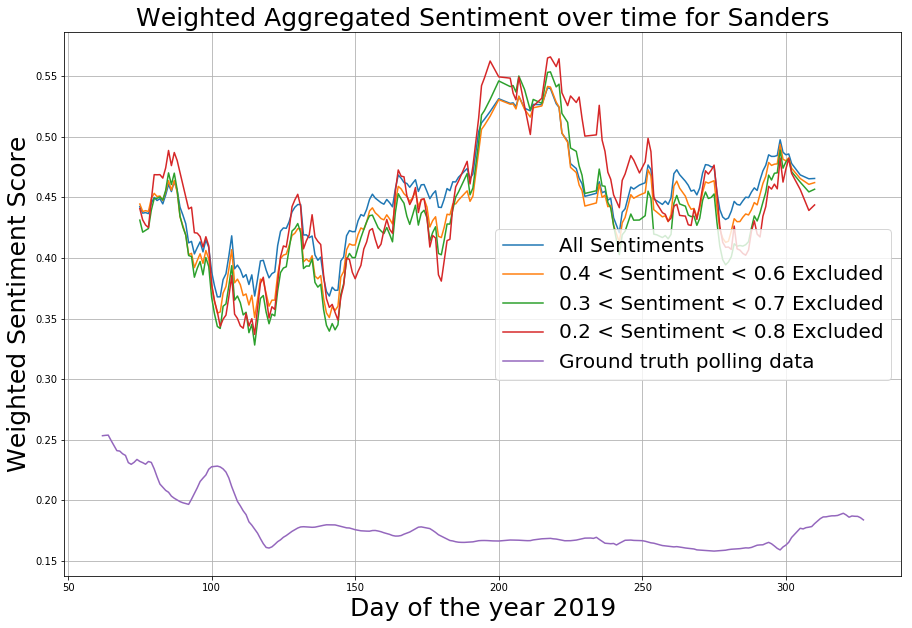

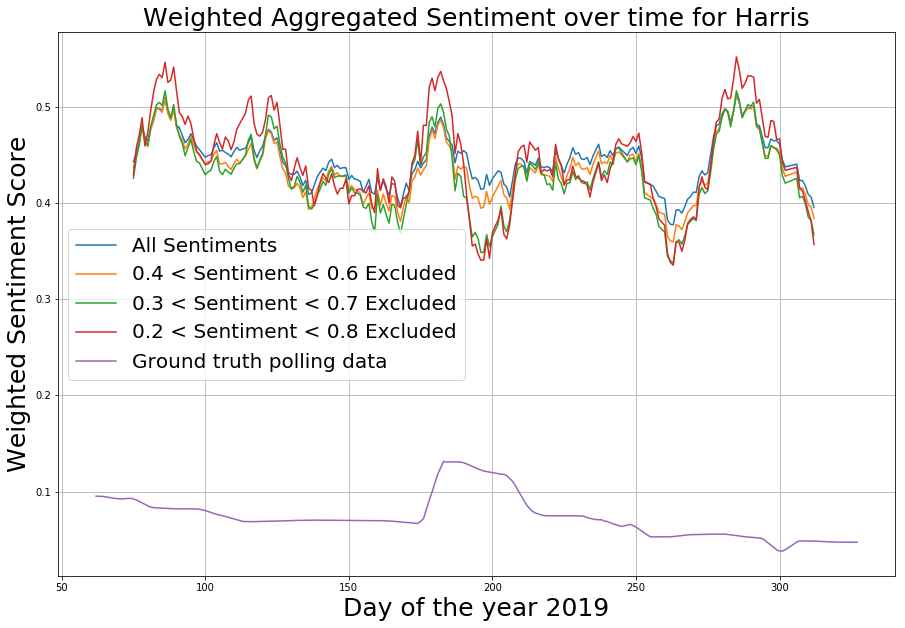

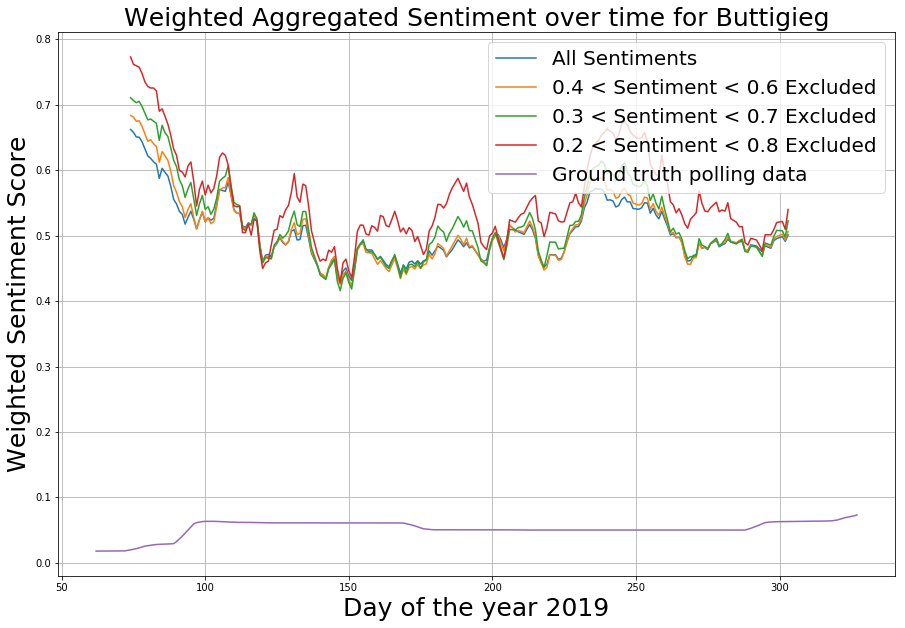

In [10]:
# plot the aggregated sentiment over time for different sentiment cut-offs
for name in names:
    df_large = dataframes[name]
    df_large.sort_values('DateTime', axis=0, ascending=True, inplace=True)
    days_df = df_large.groupby(df_large['Day of the Year']).count().index
    extreme_cutoffs = [0, 0.1, 0.2, 0.3]
    k = 15
    plt.figure(figsize = (15,10))

    for extreme_cutoff in extreme_cutoffs:

        upper_bound = 0.5-extreme_cutoff
        lower_bound = 0.5+extreme_cutoff
        new_df1 = df_large.loc[df_large['Sentiment']>= lower_bound]
        new_df2 = df_large.loc[df_large['Sentiment']<= upper_bound]
        new_df = pd.concat([new_df1, new_df2])
        new_df.sort_values('Day of the Year', axis=0, ascending=True, inplace=True)

        sub_df = new_df.copy()

        # find the count of likes and aggregated sentiment per day
        sum_likes_per_day = sub_df.groupby(sub_df['DateTime']).sum()['nlikes']
        aggr_sentiment_likes = sub_df.groupby(sub_df['DateTime']).sum()['Sentiment*Likes']
        
        # weight the aggregated sentiments
        weighted_sentiments = [aggr_sentiment_likes[k]/sum_likes_per_day[k] for k in range(len(sum_likes_per_day))]
        
        # smooth it out
        smoothed_number = pd.Series(weighted_sentiments).rolling(k).mean()
        if extreme_cutoff == 0:
            plt.plot(days_df, smoothed_number, label = 'All Sentiments')
        else:
            plt.plot(days_df, smoothed_number, label = '{} < Sentiment < {} Excluded'.format(upper_bound, lower_bound))

    plt.plot(days_truth, ground_truth_all[name]/100, label = 'Ground truth polling data')
    plt.title('Weighted Aggregated Sentiment over time for {}'.format(name), fontsize = 25)
    plt.xlabel('Day of the year 2019', fontsize = 25)
    plt.ylabel('Weighted Sentiment Score', fontsize = 25)
    plt.legend(fontsize = 20)  
    plt.grid()

In [13]:
merged = pd.merge(ground_truth_all[['Biden', 'DateTime']], dataframes['Biden'], on = 'DateTime')
merged.head()

,Biden,DateTime,Unnamed: 0,Unnamed: 0.1,tweet,nlikes,Sentiment,Day of the Year,Sentiment*Likes
0,33.819893,2019-03-03,319114,319114,Either Joe Biden or Kamala Harris. I don’t wan...,0,0.223953,62,0.000000
1,33.819893,2019-03-03,319105,319105,"Well, we know what handsy Joe Biden’s into. ???",0,0.845661,62,0.000000
2,33.819893,2019-03-03,319106,319106,"#Joe Biden, will he or won't he run for the pr...",0,0.788167,62,0.000000
3,33.819893,2019-03-03,319107,319107,Elizabeth Warren Differs With Joe Biden: Mike ...,0,0.153732,62,0.000000
4,33.819893,2019-03-03,319111,319111,"Democrats only — has what you have seen, read,...",1,0.580711,62,0.580711


C:\Users\Matthieu\Pictures\Anaconda3_2\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


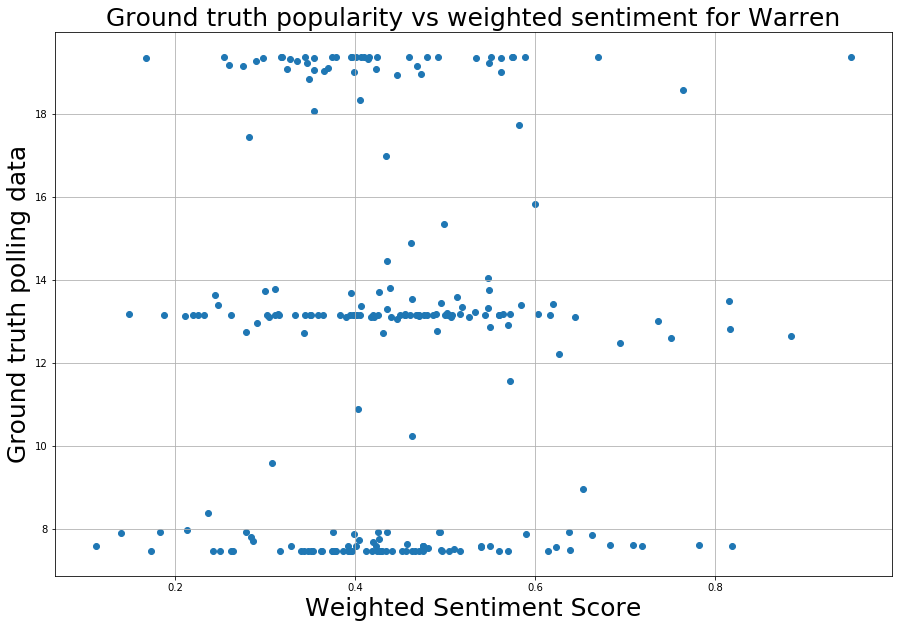

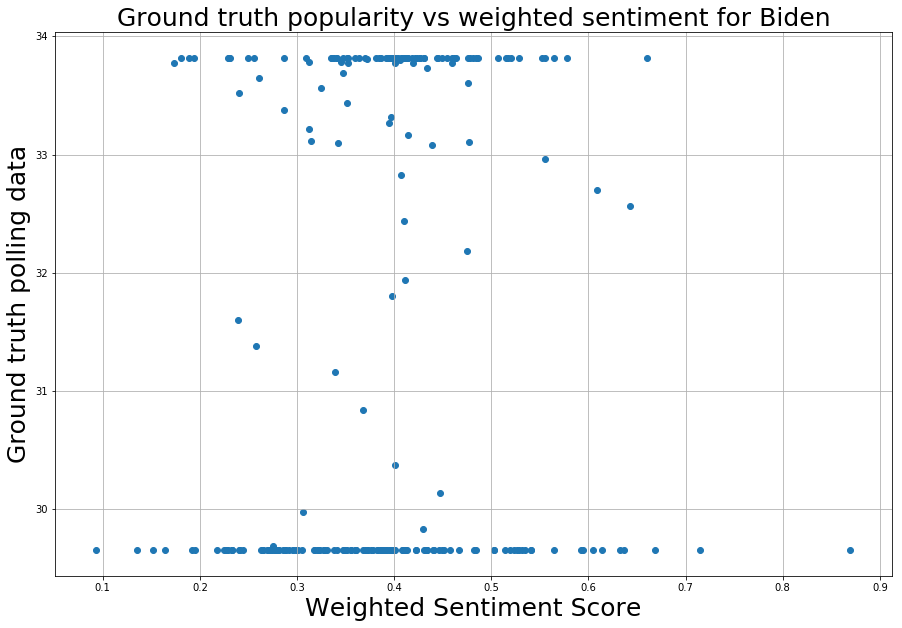

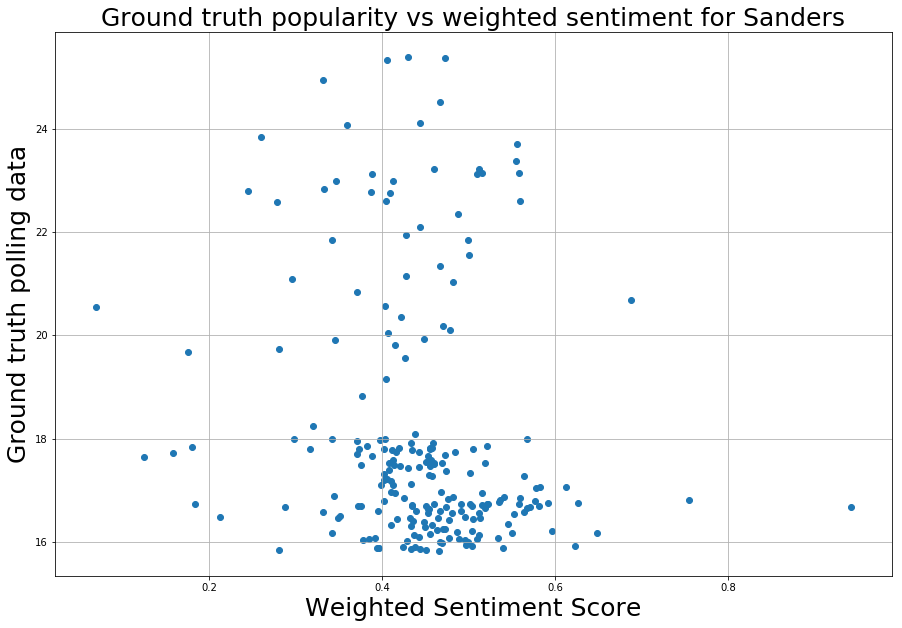

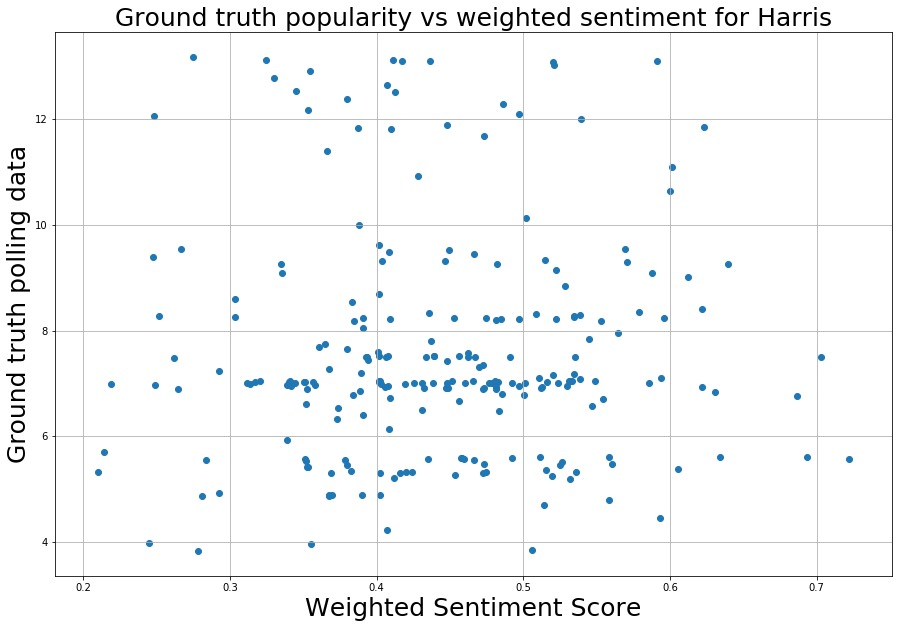

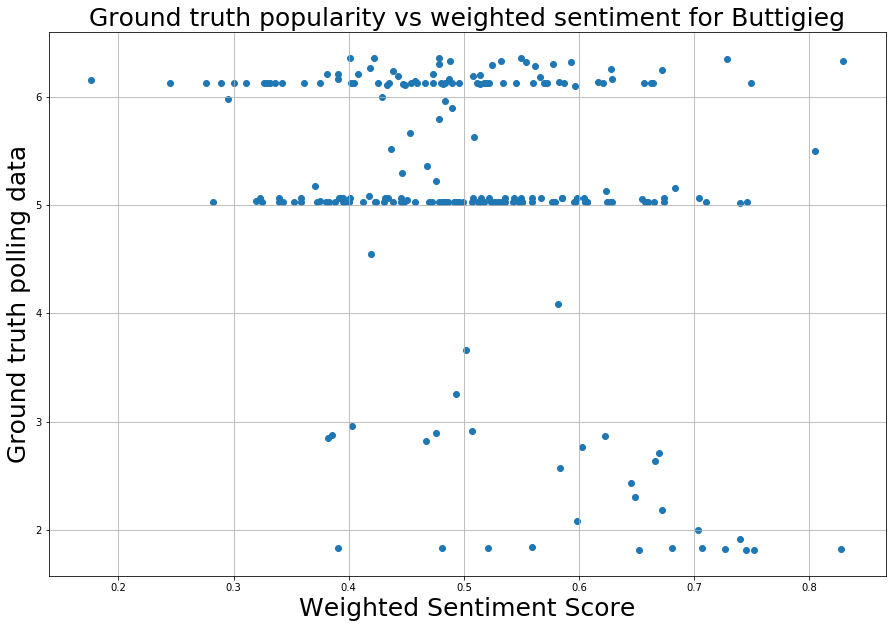

In [25]:
# plot change in ground truth vs sentiment
for name in names:
    df_large = dataframes[name]
    df_large.sort_values('DateTime', axis=0, ascending=True, inplace=True)
    
    # merge with ground truth
    df_large = pd.merge(ground_truth_all[[name, 'DateTime']], dataframes[name], on = 'DateTime')
    
    extreme_cutoffs = [0] #, 0.1, 0.2, 0.3]
    k = 15
    plt.figure(figsize = (15,10))

    for extreme_cutoff in extreme_cutoffs:

        upper_bound = 0.5-extreme_cutoff
        lower_bound = 0.5+extreme_cutoff
        new_df1 = df_large.loc[df_large['Sentiment']>= lower_bound]
        new_df2 = df_large.loc[df_large['Sentiment']<= upper_bound]
        new_df = pd.concat([new_df1, new_df2])
        new_df.sort_values('Day of the Year', axis=0, ascending=True, inplace=True)

        sub_df = new_df.copy()

        # find the count of likes and aggregated sentiment per day
        sum_likes_per_day = sub_df.groupby(sub_df['DateTime']).sum()['nlikes']
        aggr_sentiment_likes = sub_df.groupby(sub_df['DateTime']).sum()['Sentiment*Likes']
        ground_truth = sub_df.groupby(sub_df['DateTime']).mean()[name]
        
        # weight the aggregated sentiments
        weighted_sentiments = [aggr_sentiment_likes[k]/sum_likes_per_day[k] for k in range(len(sum_likes_per_day))]
        
        # smooth it out
        #smoothed_number = pd.Series(weighted_sentiments).rolling(k).mean()
        if extreme_cutoff == 0:
            plt.scatter(weighted_sentiments, ground_truth)# label = 'All Sentiments')
        else:
            plt.scatter(weighted_sentiments, ground_truth, label = '{} < Sentiment < {} Excluded'.format(upper_bound, lower_bound))

    plt.title('Ground truth popularity vs weighted sentiment for {}'.format(name), fontsize = 25)
    plt.ylabel('Ground truth polling data', fontsize = 25)
    plt.xlabel('Weighted Sentiment Score', fontsize = 25)
    #plt.legend(fontsize = 20)  
    plt.grid()

C:\Users\Matthieu\Pictures\Anaconda3_2\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


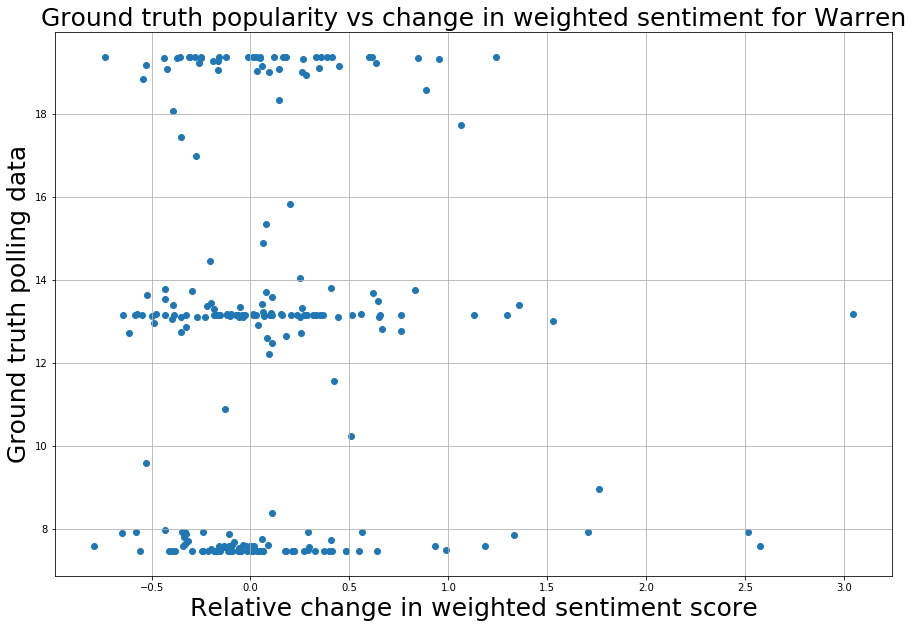

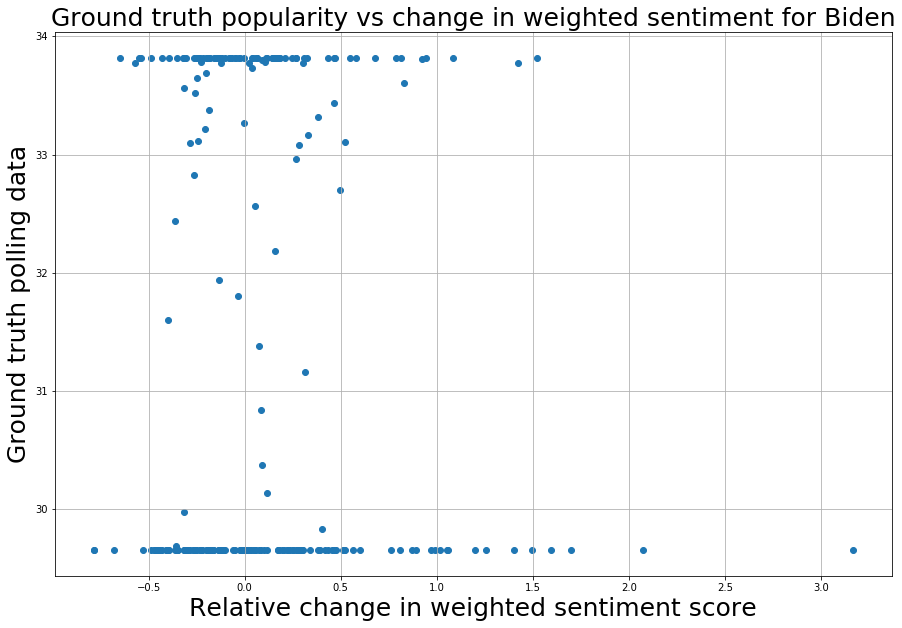

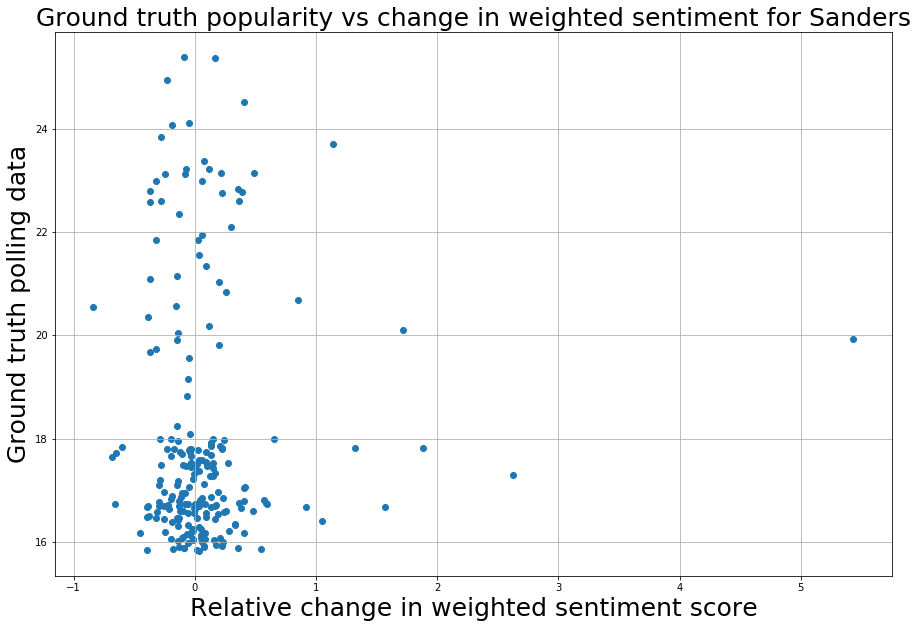

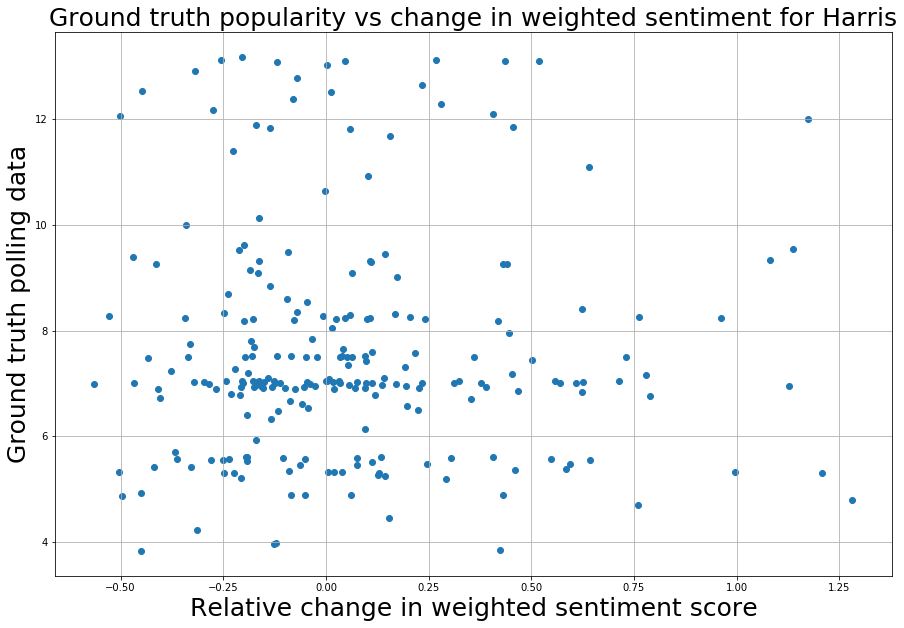

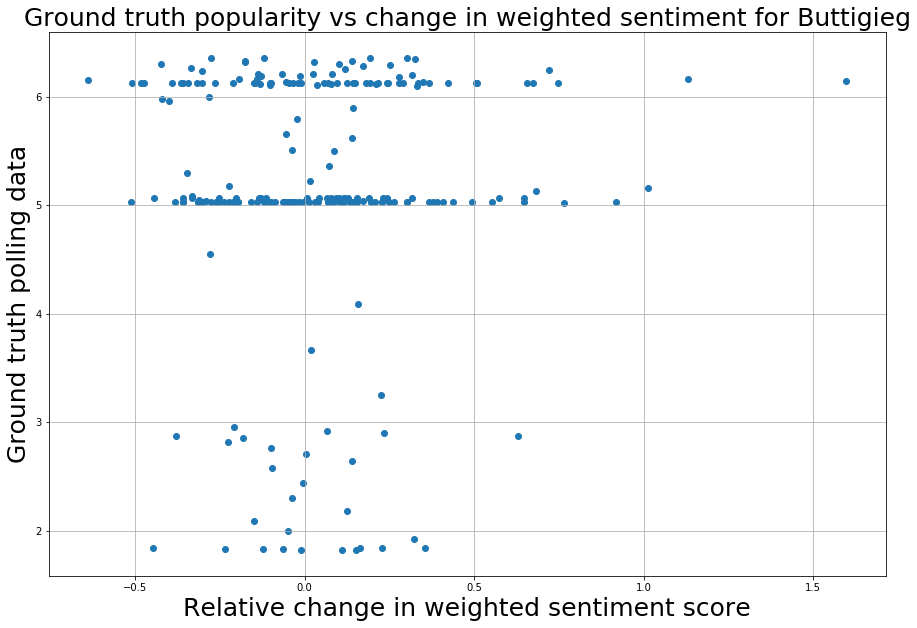

In [28]:
# plot ground truth vs change in sentiment
for name in names:
    df_large = dataframes[name]
    df_large.sort_values('DateTime', axis=0, ascending=True, inplace=True)
    
    # merge with ground truth
    df_large = pd.merge(ground_truth_all[[name, 'DateTime']], dataframes[name], on = 'DateTime')
    
    extreme_cutoffs = [0] #, 0.1, 0.2, 0.3]
    k = 15
    plt.figure(figsize = (15,10))

    for extreme_cutoff in extreme_cutoffs:

        upper_bound = 0.5-extreme_cutoff
        lower_bound = 0.5+extreme_cutoff
        new_df1 = df_large.loc[df_large['Sentiment']>= lower_bound]
        new_df2 = df_large.loc[df_large['Sentiment']<= upper_bound]
        new_df = pd.concat([new_df1, new_df2])
        new_df.sort_values('Day of the Year', axis=0, ascending=True, inplace=True)

        sub_df = new_df.copy()

        # find the count of likes and aggregated sentiment per day
        sum_likes_per_day = sub_df.groupby(sub_df['DateTime']).sum()['nlikes']
        aggr_sentiment_likes = sub_df.groupby(sub_df['DateTime']).sum()['Sentiment*Likes']
        ground_truth = sub_df.groupby(sub_df['DateTime']).mean()[name]
        
        # weight the aggregated sentiments
        y = [aggr_sentiment_likes[k]/sum_likes_per_day[k] for k in range(len(sum_likes_per_day))]
        change_agg_sent = [(y[k]-y[k-1])/y[k-1] for k in range(1,len(y)-1)]
        
        # smooth it out
        #smoothed_number = pd.Series(weighted_sentiments).rolling(k).mean()
        if extreme_cutoff == 0:
            plt.scatter(change_agg_sent, ground_truth[1:-1])# label = 'All Sentiments')
        else:
            plt.scatter(change_agg_sent, ground_truth[1:-1], label = '{} < Sentiment < {} Excluded'.format(upper_bound, lower_bound))

    plt.title('Ground truth popularity vs change in weighted sentiment for {}'.format(name), fontsize = 25)
    plt.ylabel('Ground truth polling data', fontsize = 25)
    plt.xlabel('Relative change in weighted sentiment score', fontsize = 25)
    #plt.legend(fontsize = 20)  
    plt.grid()

C:\Users\Matthieu\Pictures\Anaconda3_2\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


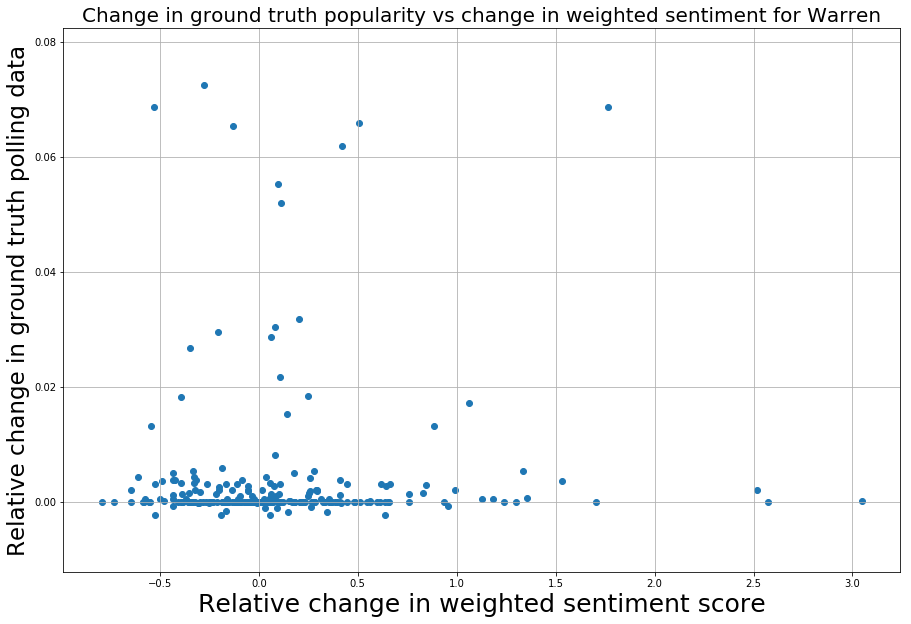

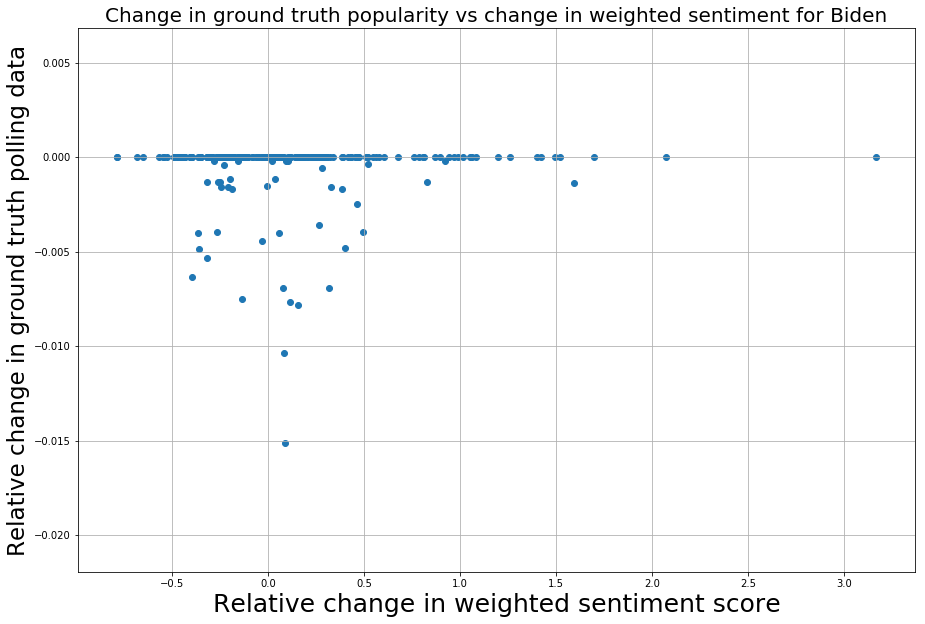

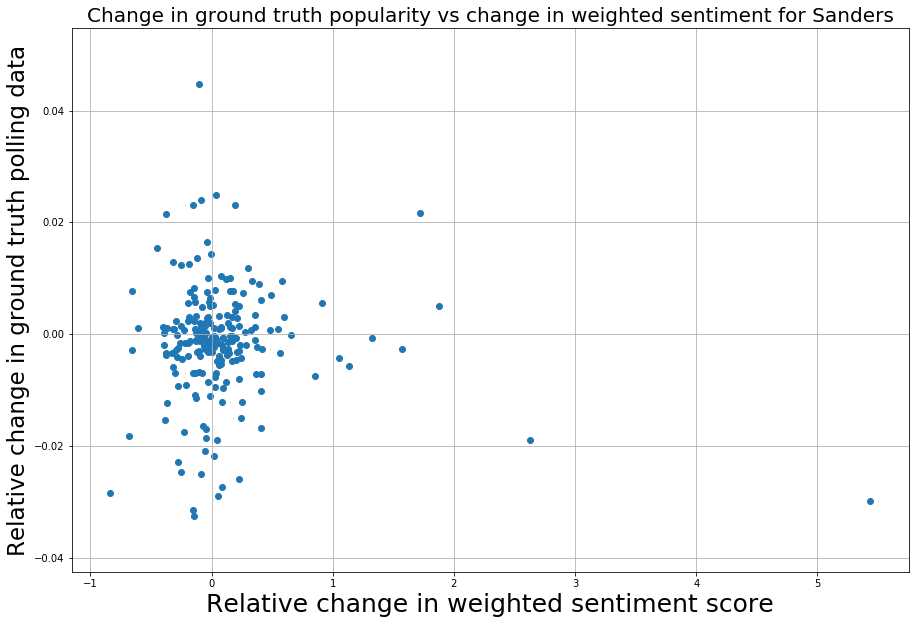

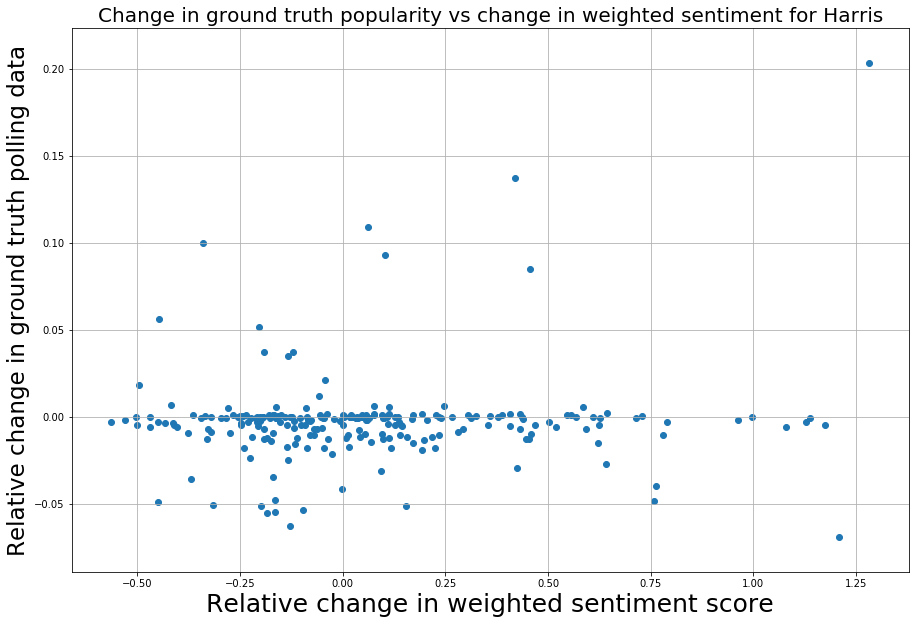

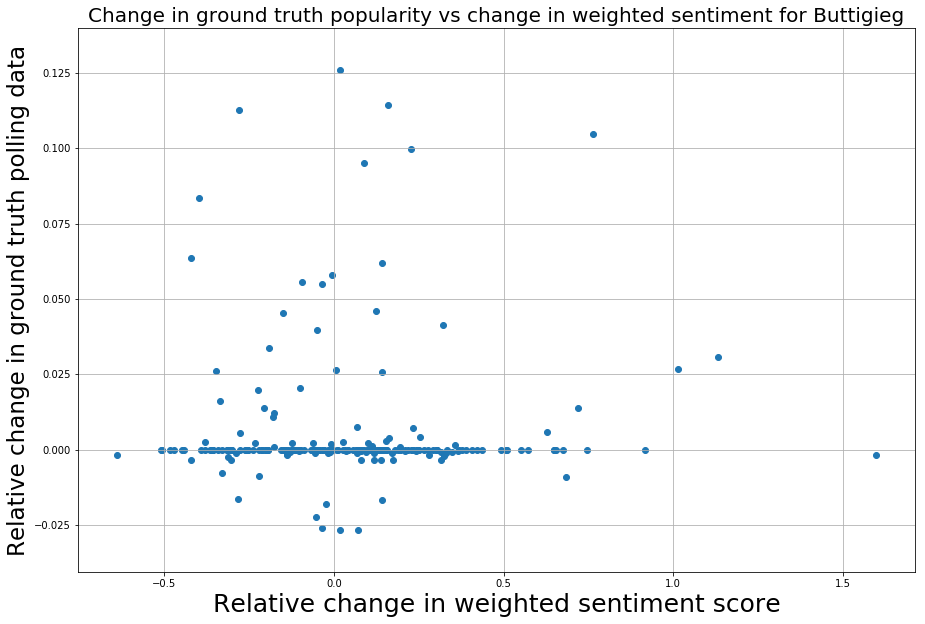

In [29]:
# plot ground truth vs change in sentiment
for name in names:
    df_large = dataframes[name]
    df_large.sort_values('DateTime', axis=0, ascending=True, inplace=True)
    
    # merge with ground truth
    df_large = pd.merge(ground_truth_all[[name, 'DateTime']], dataframes[name], on = 'DateTime')
    
    extreme_cutoffs = [0] #, 0.1, 0.2, 0.3]
    k = 15
    plt.figure(figsize = (15,10))

    for extreme_cutoff in extreme_cutoffs:

        upper_bound = 0.5-extreme_cutoff
        lower_bound = 0.5+extreme_cutoff
        new_df1 = df_large.loc[df_large['Sentiment']>= lower_bound]
        new_df2 = df_large.loc[df_large['Sentiment']<= upper_bound]
        new_df = pd.concat([new_df1, new_df2])
        new_df.sort_values('Day of the Year', axis=0, ascending=True, inplace=True)

        sub_df = new_df.copy()

        # find the count of likes and aggregated sentiment per day
        sum_likes_per_day = sub_df.groupby(sub_df['DateTime']).sum()['nlikes']
        aggr_sentiment_likes = sub_df.groupby(sub_df['DateTime']).sum()['Sentiment*Likes']
        ground_truth = sub_df.groupby(sub_df['DateTime']).mean()[name]
        change_truth = [(ground_truth[k]-ground_truth[k-1])/ground_truth[k-1] for k in range(1,len(ground_truth)-1)]
        
        # weight the aggregated sentiments
        y = [aggr_sentiment_likes[k]/sum_likes_per_day[k] for k in range(len(sum_likes_per_day))]
        change_agg_sent = [(y[k]-y[k-1])/y[k-1] for k in range(1,len(y)-1)]
        
        # smooth it out
        #smoothed_number = pd.Series(weighted_sentiments).rolling(k).mean()
        if extreme_cutoff == 0:
            plt.scatter(change_agg_sent, change_truth) #label = 'All Sentiments')
        else:
            plt.scatter(change_agg_sent, change_truth, label = '{} < Sentiment < {} Excluded'.format(upper_bound, lower_bound))

    plt.title('Change in ground truth popularity vs change in weighted sentiment for {}'.format(name), fontsize = 20)
    plt.ylabel('Relative change in ground truth polling data', fontsize = 23)
    plt.xlabel('Relative change in weighted sentiment score', fontsize = 25)
    #plt.legend(fontsize = 20)  
    plt.grid()